<a href="https://colab.research.google.com/github/top-data/Soil_moisture/blob/main/SM_inputs4model_updated_satellites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize(project='ee-mhdsaki')

In [ ]:
import pandas as pd

def image_to_df(sat_product, bands, gps, dates):
    """
    Inputs: satellite data product, desired bands, gps, date
    Output: pandas dataframe with selected bands and date
    Returns:

    """
    # Define the ImageCollection
    image = ee.ImageCollection(sat_product) \
              .select(bands) \
              .filterDate(dates[0], dates[1])

    # Define a global bounding box geometry
    global_geometry = ee.Geometry.Polygon(
        [[[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]]
    )

    # Define a local bounding box geometry
    local_geometry = ee.Geometry.Rectangle([30, -10, 40, 10])

    # Define a single geometry
    single_geometry = ee.Geometry.Point(gps)

    # Function to extract the date and mean values of 'ssm' and 'susm'
    def image_to_dict(image):
        # Get the date of the image
        date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
        # Get the mean soil moisture values over the global geometry
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=single_geometry, # or local_geometry # or global_geometry
            scale=10000,
            maxPixels=1e9
        )
        return ee.Feature(None, {
            'date': date,
            bands[0]: stats.get(bands[0]),
            bands[1]: stats.get(bands[1])
        })

    # Map the function over the ImageCollection
    data_features = image.map(image_to_dict)

    # Convert the ImageCollection to a FeatureCollection, then to a list of dictionaries
    smap_dicts = data_features.getInfo()['features']

    # Convert to pandas DataFrame
    data_dict = [{'date': f['properties']['date'],
                  bands[0]: f['properties'][bands[0]],
                  bands[1]: f['properties'][bands[1]]} for f in smap_dicts]

    df = pd.DataFrame(data_dict)

    return df

# Example usage
sat_product = 'NASA/SMAP/SPL4SMGP/007'
bands = ['sm_surface', 'sm_rootzone']
gps = [149.2659, -30.0996]
dates = ['2024-07-01', '2024-08-14']
smap_df = image_to_df(sat_product, bands, gps, dates)
smap_df.tail()


,date,sm_surface,sm_rootzone
323,2024-08-10,0.316198,0.341297
324,2024-08-10,0.315487,0.341172
325,2024-08-10,0.315257,0.341085
326,2024-08-10,0.315645,0.341043
327,2024-08-10,0.329283,0.342201


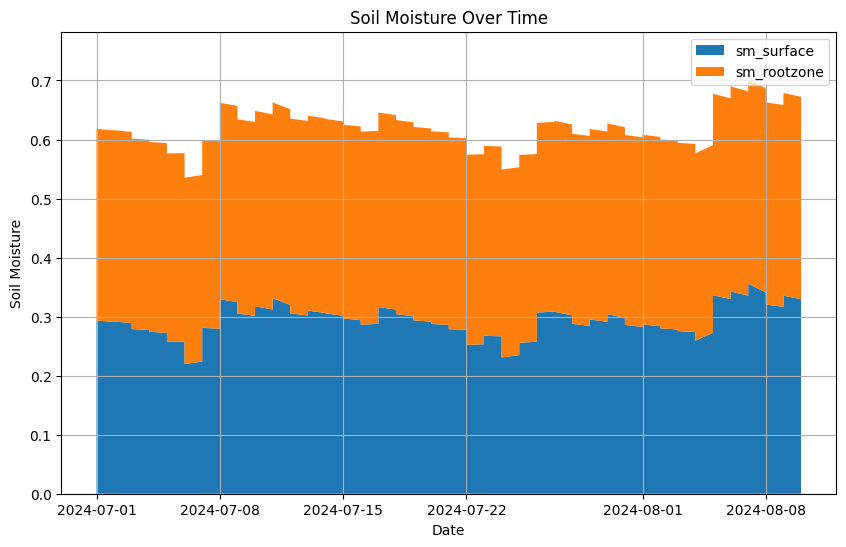

In [ ]:
# plot a stacked area chart to show sm_surface and sm_rootzone vs date

import pandas as pd
import matplotlib.pyplot as plt

smap_df['date'] = pd.to_datetime(smap_df['date'])  # Convert 'date' to datetime
smap_df.set_index('date', inplace=True)  # Set 'date' as index

# Plot stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(smap_df.index, smap_df['sm_surface'], smap_df['sm_rootzone'], labels=['sm_surface', 'sm_rootzone'])
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.title('Soil Moisture Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import folium

## Preprocessing functions to stack predictors

> Add blockquote



In [ ]:
def toNatural(img):
    '''
    Description: function that converts dB to natural values for S1 image
    Inputs:
        img: ee.Image
    Outputs:
        ee.Image
    '''
    img = ee.Image(img)
    props = img.propertyNames()
    return ee.Image(10.0).pow(img.select(0).divide(10.0)).copyProperties(img, props)


def force_time_end(img):
    '''
    Description: set time_end in images
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    img = ee.Image(img)
    properties = img.propertyNames()
    condition = ee.Algorithms.If(properties.contains('system:time_end'),
                                 img,
                                 img.set('system:time_end', img.get('system:time_start')))
    return ee.Image(condition)


def toDB(img):
    '''
    Description: function that converts to dB values for S1 image
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    img = ee.Image(img)
    properties = img.propertyNames()
    return img.log10().multiply(10.0).copyProperties(img, properties)


# DOI: 10.1109/TGRS.2018.2858004
def edgeRemoval(img):
    '''
    Description: clamp sentinel 1 db values between -20 and -5
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    img = ee.Image(img)
    return img.updateMask(img.gt(-20).And(img.lt(-5)))


def gaussianFilter(img):
    '''
    Description: applies a 3x3 kernel gaussian filter to image
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    properties = img.propertyNames()
    img = ee.Image(resampleImage(ee.Image(edgeRemoval(img))))
    return img.convolve(ee.Kernel.gaussian(3, 3)).copyProperties(img,
                                                                 properties)


def angleCorrection2(slope):
    '''
    Description: applies correction to S1 image based on incidence angle
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    def inner(img):
        img = ee.Image(img)
        props = img.propertyNames()
        ols = img.addBands(img.select('VV').subtract(ee.Image(slope).multiply(img.select('angle2').subtract(30))).rename('sigma30'))
        return ols.copyProperties(img, props)
    return inner


def resampleAngle(img):
    '''
    Description: Bicubic resampling of incidence angle band in S1 images
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    img = ee.Image(img)
    props = img.propertyNames()
    resampled = img.addBands(img.select('angle').resample('bicubic').rename('angle2'))
    return resampled.copyProperties(img, props)


def rSSM(minimum, maximum):
    '''
    Description: calculates the rSSM based on normalization with 2 extremes
    Input:
        img: ee.Image
        minimum: ee.Image corresponding to 5 percentil in sigma30 collection
        maximum: ee.Image corresponding to 95 percentil in sigma30 collection
    Output:
        ee.Image
    '''
    def inner(img):
        img = ee.Image(img)
        props = img.propertyNames()
        img1 = img.where(img.select('sigma30').lt(minimum), minimum)
        img1 = img1.select('sigma30').where(img1.select('sigma30').gt(maximum), maximum)
        rSSM = img1.select('sigma30').subtract(minimum).divide(maximum.subtract(minimum)).rename('rSSM')
        return img.select('VV').addBands(rSSM).copyProperties(img, props)
    return inner


def resampleImage(img):
    '''
    Description: resamples S1 image to lower resolution (90 m)
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    img = ee.Image(img)
    props = img.propertyNames()
    return img.select('VV').reduceResolution('mean',
                                             False,
                                             102).reproject('EPSG:4326',
                                                            None,
                                                            90).copyProperties(img, props)


def pre_process(img):
    '''
    Description: preprocess images for sigma30 collection generation
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    img = ee.Image(img)
    properties = img.propertyNames()
    resampled = ee.Image(gaussianFilter(ee.Image(toDB(img.select('VV')))))
    angle = ee.Image(resampleAngle(img.select('angle'))).select('angle2').reproject('EPSG:4326', None, 90)
    return ee.Image(resampled).addBands(angle).copyProperties(img, properties)


def get_rssm(geometry):
    '''
    Description: Creates collection of rSSM
    Input:
        geometry: ee.Geometry
    Output:
        ee.ImageCollection
    '''
    coll = S1.filterDate(start, end).filterMetadata('instrumentMode', "equals", 'IW').filterBounds(geometry)
    coll = coll.filterMetadata('orbitProperties_pass', 'equals', 'DESCENDING')
    coll = coll.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    coll = coll.select(['VV', 'angle']).map(force_time_end)
    preColl = coll.map(pre_process)
    LinearReducer = ee.Reducer.linearFit()
    linear2 = ee.ImageCollection(preColl).select(['angle2', 'VV']).reduce(LinearReducer)
    beta = linear2.select('scale')
    sigma30 = preColl.map(angleCorrection2(beta))
    percentiles = sigma30.reduce(ee.Reducer.percentile([5, 95], ['min', 'max']))
    min = percentiles.select('sigma30_min')
    max = percentiles.select('sigma30_max')
    soilMoi = sigma30.map(rSSM(min, max))
    return soilMoi


def attach_chirps(img):
    '''
    Description: Aggregates CHIRPS rainfall between dates
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    date0 = ee.Date(img.get('system:time_start'))
    date1 = ee.Date(img.get('system:time_end'))
    chirp = chirps.filterDate(date0, date1).sum()
    return img.set('chirp', chirp)


def cat_modis(img):
    '''
    Description: Concatenates MODIS inputs as a multiband image
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    img = ee.Image(img)
    props = img.propertyNames()
    sr = img.select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03',
                     'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06',
                     'sur_refl_b07']).multiply(0.0001)
    ndvi = sr.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('NDVI')
    lst = ee.Image(ee.List(img.get('lst')).get(0))
    lst = lst.select(['LST_Day_1km', "LST_Night_1km", "Emis_31", "Emis_32"])
    lst = lst.multiply(ee.Image.cat([ee.Image(0.02), ee.Image(0.02), ee.Image(0.002), ee.Image(0.002)]))
    retrieve = sr.addBands(lst).addBands(ndvi).select(modis_bands)
    return retrieve.copyProperties(img, props)


def wrap(img):
    '''
    Description: retrieves CHIRPS image from properties
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    return ee.Image(img.get('chirp'))


def get_image(img):
    '''
    Description: Stacks all bands together for the predictor images
    Input:
        img: ee.Image
    Output:
        ee.Image
    '''
    img =  ee.Image(img)
    smap = ee.ImageCollection.fromImages(ee.List(img.get('images')).slice(0,10)).toBands().rename(smap_bands)
    chirp = ee.ImageCollection.fromImages(ee.List(img.get('images')).slice(0,10)).map(wrap).toBands().rename(chirps_bands)
    modis = ee.Image(ee.List(img.get('modis')).get(0)).select(modis_bands)
    sampleImg = img.addBands(modis).addBands(Merit).addBands([CLY, AWC, SOC]).addBands(smap).addBands(chirp).addBands(LUx).addBands(elevation)
    return sampleImg


def inner2(fea):
    '''
    Description: samples predictor image based on feature
    Input:
        fea: ee.Feature
    Output:
        ee.Feature
    '''
    def inner(img):
        sampleImg = ee.Image(get_image(img))
        container = ee.Feature(ee.FeatureCollection(sampleImg.sample(region=fea.geometry(),
                                                                     scale=90,
                                                                     dropNulls=False)).first())
        container = container.setMulti({'date': ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'),
                                        'id': fea.get('ID'),
                                        'site':fea.get('site')})
        return container
    return inner


def combining_datasets(fea):
    '''
    Description: Combines collections based on feature
    Input:
        fea: ee.Feature
    Output:
        ee.ImageCollection
    '''
    s1_collection = get_rssm(fea.geometry())
    filter = ee.Filter.And(ee.Filter.maxDifference(difference=35*1000*86400,
                                                   leftField=timeField,
                                                   rightField=timeField),
                           ee.Filter.greaterThan(leftField=timeField,
                                                 rightField=timeField))
    joined = ee.Join.saveAll(matchesKey='images',
                             measureKey='SMAP',
                             ordering=timeField,
                             ascending=False).apply(primary=s1_collection,
                                                    secondary=SMAP,
                                                    condition=filter)
    filter2 = ee.Filter.And(ee.Filter.greaterThanOrEquals(leftField=timeField,
                                                          rightField=timeField),
                            ee.Filter.lessThanOrEquals(leftField='system:time_end',
                                                       rightField='system:time_end'))
    joined = ee.Join.saveAll(matchesKey='modis',
                             ordering=timeField,
                             ascending=True).apply(primary=joined,
                                                   secondary=Modis,
                                                   condition=filter2)
    return joined


def to_drive(fea):
    '''
    Description: Samples Collection based on feature
    Input:
        fea: ee.Feature
    Output:
        ee.FeatureCollection
    '''
    joined = combining_datasets(fea)
    retrieve = joined.map(inner2(fea), True)
    return retrieve


def get_collection(fea):
    '''
    Description: Creates predictor ImageCollection based on feature
    Input:
        fea: ee.Feature
    Output:
        ee.ImageCollection
    '''
    joined = combining_datasets(fea)
    collection = joined.map(get_image)
    return collection


# Using entire S1 image leads to memory errors, but this is the function to get geometry from images
def get_geometry(img):
    '''
    Description: Returns the countour of Sentinel images as Feature
    Input:
        img: ee.Image
    Output:
        ee.Feature
    '''
    contour = ee.Geometry(ee.Image(img).get('system:footprint')).coordinates()
    return ee.Feature(ee.Geometry.Polygon(contour))


def to_yyyymmdd(i):
    '''
    Description: Formats dates into %Y-%m-%d
    Input:
        i: string or ee.Date
    Output:
        string
    '''
    return ee.Date(i).format('YYYY-MM-dd')


## Parameters definition

In [ ]:
start = '2016-01-01'
end = '2021-05-01'
timeField = 'system:time_start'

smap_bands = ['smap1', 'ssmap1', 'smap2', 'ssmap2', 'smap3', 'ssmap3',
              'smap4', 'ssmap4', 'smap5', 'ssmap5', 'smap6', 'ssmap6',
              'smap7', 'ssmap7', 'smap8', 'ssmap8', 'smap9', 'ssmap9',
              'smap10', 'ssmap10']

chirps_bands = ['chirps1', 'chirps2', 'chirps3', 'chirps4', 'chirps5',
                'chirps6', 'chirps7', 'chirps8', 'chirps9', 'chirps10']

modis_bands = ['LST_Day_1km', "LST_Night_1km", "Emis_31", "Emis_32",
               'NDVI', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03',
               'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']

timeFilter = ee.Filter.equals(leftField=timeField,
                              rightField=timeField)

saveAllJoin = ee.Join.saveAll(matchesKey='lst',
                              ordering=timeField,
                              ascending=True)

## Loading of Inputs

In [ ]:
S1 = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
SMAP = ee.ImageCollection("NASA_USDA/HSL/SMAP10KM_soil_moisture").select(['ssm', 'susm']).filterDate('2000-01-01', '2021-11-29')
AWC = ee.Image('CSIRO/SLGA/AWC').select(['AWC_000_005_EV', 'AWC_005_015_EV', 'AWC_015_030_EV', 'AWC_030_060_EV']).rename(['AWC1', 'AWC2', 'AWC3', 'AWC4'])
CLY = ee.Image('CSIRO/SLGA/CLY').select(['CLY_000_005_EV', 'CLY_005_015_EV', 'CLY_015_030_EV', 'CLY_030_060_EV']).rename(['CLY1', 'CLY2', 'CLY3', 'CLY4'])
SOC = ee.Image('CSIRO/SLGA/SOC').select(['SOC_000_005_EV', 'SOC_005_015_EV', 'SOC_015_030_EV', 'SOC_030_060_EV']).rename(['SOC1', 'SOC2', 'SOC3', 'SOC4'])
Merit = ee.Image("MERIT/Hydro/v1_0_1").select(['upa', 'hnd'])
LST = ee.ImageCollection('MODIS/006/MOD11A2')
SR = ee.ImageCollection('MODIS/006/MOD09A1')
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
LU = ee.Image("users/ignaciofuentessanroman/AU/clum_50m1218m")
MCD = ee.ImageCollection("MODIS/006/MCD12Q1").select('LC_Type1').filterDate('2017-01-01', '2021-01-01').reduce(ee.Reducer.mode())
elevation = ee.Image("CGIAR/SRTM90_V4")
slope = ee.Terrain.slope(elevation).rename('slope')
aspect = ee.Terrain.aspect(elevation).rename('aspect')
elevation = elevation.addBands([slope, aspect])

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for NASA_USDA/HSL/SMAP10KM_soil_moisture! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_SMAP10KM_soil_moisture

  warnings.warn(warning, category=DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD11A2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A2

  warnings.warn(warning, category=DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD09A1! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers

## Land cover standardisation

In [ ]:
LUx = LU.where(LU.lte(210), 1) #pasture
LUx = LUx.where(LU.gt(210).And(LU.lte(314)), 2) # forest
LUx = LUx.where(LU.gt(319).And(LU.lte(325)), 1)
LUx = LUx.where(LU.gte(330).And(LU.lte(360)), 3) # agri
LUx = LUx.where(LU.gt(359).And(LU.lte(400)), 1) #
LUx = LUx.where(LU.gte(410).And(LU.lt(420)), 4) # irri
LUx = LUx.where(LU.gte(420).And(LU.lt(430)), 4) #
LUx = LUx.where(LU.gte(430).And(LU.lte(465)), 4)
LUx = LUx.where(LU.gte(510).And(LU.lt(600)), 1)
LUx = LUx.where(LU.gt(600).And(LU.lt(650)), 1)
LUx = LUx.where(LU.gte(650), 1)
LUx = LUx.where(LUx.eq(1).And(MCD.lte(5)), 2)
LUx = LUx.where(LUx.eq(1).And(MCD.gte(5)).And(MCD.lte(6)), 5)
LUx = LUx.where(LUx.eq(1).And(MCD.gte(7)).And(MCD.lte(9)), 6)
LUx = LUx.rename('LU')

In [ ]:
irri = LUx.eq(4)
past = LUx.eq(1)
agri = LUx.eq(3)
fore = LUx.eq(2)
sava = LUx.gte(5)
LUx = ee.Image.cat([irri.rename('irri'), past.rename('past'), agri.rename('agri'),
                    fore.rename('fore'), sava.rename('sava')])

## Parameters to change for image selection

In [ ]:
geo = ee.Geometry.Point([149.2659, -30.0996])
date = '2019-12-15'

## Getting Collection of predictor images based on geometry

In [ ]:
SMAP = SMAP.map(attach_chirps)
Modis = saveAllJoin.apply(SR, LST, timeFilter)
Modis = ee.ImageCollection(Modis.map(cat_modis))
collection = get_collection(ee.Feature(geo))

In [ ]:
print(collection.aggregate_array('system:time_start').map(to_yyyymmdd).getInfo())

['2016-01-07', '2016-01-19', '2016-01-31', '2016-01-31', '2016-02-12', '2016-02-24', '2016-03-07', '2016-03-19', '2016-03-31', '2016-04-12', '2016-04-24', '2016-05-06', '2016-05-18', '2016-05-30', '2016-06-11', '2016-07-05', '2016-07-17', '2016-07-29', '2016-08-10', '2016-08-22', '2016-09-03', '2016-09-15', '2016-09-27', '2016-10-09', '2016-10-21', '2016-11-02', '2016-11-14', '2016-11-26', '2016-12-08', '2016-12-20', '2017-01-01', '2017-01-13', '2017-01-25', '2017-02-06', '2017-02-18', '2017-03-02', '2017-03-14', '2017-03-26', '2017-04-07', '2017-04-19', '2017-05-01', '2017-05-13', '2017-05-25', '2017-06-06', '2017-06-18', '2017-06-30', '2017-07-12', '2017-07-24', '2017-08-05', '2017-08-17', '2017-08-29', '2017-09-10', '2017-09-22', '2017-10-04', '2017-10-16', '2017-10-28', '2017-11-09', '2017-11-21', '2017-12-03', '2017-12-15', '2017-12-27', '2018-01-08', '2018-01-20', '2018-02-01', '2018-02-13', '2018-02-25', '2018-03-09', '2018-03-21', '2018-04-02', '2018-04-14', '2018-04-26', '2018

## Setting band names

In [ ]:
ixs = range(1, 11)
smap_cols = ['smap{}'.format(str(n)) for n in ixs]
ssmap_cols = ['ssmap{}'.format(str(n)) for n in ixs]
chirps_cols = ['chirps{}'.format(str(n)) for n in ixs]

lstm_cols = smap_cols+chirps_cols+ssmap_cols

#removed hnd, upa, emissivity
mlp_cols = ['VV', 'rSSM',
            'AWC1', 'AWC2', 'AWC3', 'AWC4',
            'CLY1', 'CLY2', 'CLY3', 'CLY4',
            'SOC1', 'SOC2', 'SOC3', 'SOC4',
            'LST_Day_1km', 'LST_Night_1km',
            'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03',
            'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07',
            'NDVI', 'irri', 'past', 'agri', 'fore', 'sava']

bands = lstm_cols + mlp_cols

## Input image

In [ ]:
img = ee.Image(collection.filterDate(date, '2022-01-01').first()).select(bands)

## Plotting some input bands and geometry

In [ ]:
map0 = ee.Image(img).select('VV').getMapId({'min':-20, 'max':-5, })
mapid = ee.Image(img).select('rSSM').getMapId({'min':0, 'max':1, 'palette':'FF0000, FFFF00, 00FF00, 00FFFF, 0000FF'})
map = folium.Map(location=ee.Feature(geo).geometry().coordinates().getInfo()[::-1], zoom_start=10)
folium.TileLayer(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='satellite',
  ).add_to(map)
folium.TileLayer(
    tiles=map0['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='VV',
  ).add_to(map)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='rssm',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [ ]:
mapid = ee.Feature(get_geometry(img)).getMapId()
map = folium.Map(location=ee.Feature(geo).geometry().coordinates().getInfo()[::-1], zoom_start=10)
folium.TileLayer(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='satellite',
  ).add_to(map)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='geometry',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

## Exporting predictor image

In [ ]:
date = ee.Date(img.get('system:time_start')).format('YYYY_MM_dd').getInfo()
geo_exp = ee.Geometry.Polygon([[[149.13340337807065, -30.108940652709176],
                                [149.13340337807065, -30.516764241304145],
                                [149.72117193275815, -30.516764241304145],
                                [149.72117193275815, -30.108940652709176]]], None, False)
ee.batch.Export.image.toDrive(img.toFloat().clip(geo_exp),
                              'moist_input_{}'.format(date),
                              region=geo_exp,
                              scale=90,
                              maxPixels=1e13).start()


## Extracting data from image collection

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [ ]:
# prompt: can you make the code in cell [149] more efficient using data conversion from earth engine instead of pandas? the current version is very slow

import pandas as pd

# Get a list of dates for which you want to extract data
def generate_date_points(start_date, end_date, num_points=6):
    # Generate date range with the desired number of points
    dates = pd.date_range(start=start_date, end=end_date, periods=num_points)
    return dates.strftime('%Y-%m-%d').tolist()
start_date = '2016-01-07'
end_date = '2020-06-26'
date_points = generate_date_points(start_date, end_date)


dates = ['2020-01-07', '2020-01-19', '2020-01-31', '2020-02-12']


# Initialize an empty list to store data for each date
data_list = []

for date in dates: #date_points:
    img = ee.Image(collection.filterDate(date, end_date).first()).select(bands)

    # Sample the image at the given geometry and convert to a dictionary.
    sampled_dict = img.sampleRegions(
        collection=ee.FeatureCollection([ee.Feature(geo)]),
        geometries=True
    ).first().toDictionary().getInfo()

    sampled_dict['date'] = date  # Add a 'date' column
    data_list.append(sampled_dict)

# Create a DataFrame from the list of dictionaries.
df_combined = pd.DataFrame(data_list)
df_combined


,AWC1,AWC2,AWC3,AWC4,CLY1,CLY2,CLY3,CLY4,LST_Day_1km,LST_Night_1km,...,ssmap8,ssmap9,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,date
0,18.484795,18.427914,18.284384,17.609713,51.587589,52.814873,56.252636,56.363281,319.74,296.40,...,15.214204,15.035429,0.1529,0.2541,0.0810,0.1165,0.3300,0.3393,0.2849,2020-01-07
1,18.484795,18.427914,18.284384,17.609713,51.587589,52.814873,56.252636,56.363281,318.04,293.76,...,14.752920,15.114655,0.1177,0.2005,0.0608,0.0892,0.2601,0.2717,0.2319,2020-01-19
2,18.484795,18.427914,18.284384,17.609713,51.587589,52.814873,56.252636,56.363281,317.14,296.12,...,16.488646,15.823699,0.1190,0.2061,0.0609,0.0930,0.2542,0.2652,0.2248,2020-01-31
3,18.484795,18.427914,18.284384,17.609713,51.587589,52.814873,56.252636,56.363281,310.64,294.70,...,38.506371,28.771904,0.1148,0.2341,0.0618,0.0939,0.2761,0.2676,0.2144,2020-02-12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_save = 'drive/MyDrive/SoilMoisture/'
df_combined.to_csv(path_to_save + 'df_combined.csv', index=False)

In [ ]:
path_to_save = 'drive/MyDrive/SoilMoisture/'

df_combined = pd.read_csv(path_to_save + 'df_combined.csv')
df_combined

,AWC1,AWC2,AWC3,AWC4,CLY1,CLY2,CLY3,CLY4,LST_Day_1km,LST_Night_1km,NDVI,SOC1,SOC2,SOC3,SOC4,VV,agri,chirps1,chirps10,chirps2,chirps3,chirps4,chirps5,chirps6,chirps7,chirps8,chirps9,fore,irri,past,rSSM,sava,smap1,smap10,smap2,smap3,smap4,smap5,smap6,smap7,smap8,smap9,ssmap1,ssmap10,ssmap2,ssmap3,ssmap4,ssmap5,ssmap6,ssmap7,ssmap8,ssmap9,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,date
0,18.484795,18.427914,18.284384,17.609713,51.587589,52.814873,56.252636,56.363281,319.74,296.40,0.248649,1.401983,1.039546,0.761962,0.752085,-15.389249,0,3.929220,0.000000,0,0.000000,0.000000,0.000000,1.125543,4.501278,0.000000,0.000000,0,1,0,0.226955,0,2.661952,2.317672,2.327763,2.257778,2.268336,2.268092,2.257778,2.257778,2.257778,2.257778,15.823699,15.267673,15.439281,14.988109,14.752920,15.114655,15.138806,14.898921,15.214204,15.035429,0.1529,0.2541,0.0810,0.1165,0.3300,0.3393,0.2849,2020-01-07
1,18.484795,18.427914,18.284384,17.609713,51.587589,52.814873,56.252636,56.363281,318.04,293.76,0.260214,1.401983,1.039546,0.761962,0.752085,-15.523320,0,42.675825,1.125543,0,21.929468,0.000000,3.929220,0.000000,0.000000,0.000000,0.000000,0,1,0,0.187735,0,8.652120,2.257778,4.953379,10.454453,2.257778,2.661952,2.327763,2.257778,2.268336,2.268092,28.771904,15.138806,36.741009,22.355713,16.488646,15.823699,15.439281,14.988109,14.752920,15.114655,0.1177,0.2005,0.0608,0.0892,0.2601,0.2717,0.2319,2020-01-19
2,18.484795,18.427914,18.284384,17.609713,51.587589,52.814873,56.252636,56.363281,317.14,296.12,0.267918,1.401983,1.039546,0.761962,0.752085,-15.440801,0,7.687464,0.000000,0,0.000000,9.049803,42.675825,0.000000,21.929468,0.000000,3.929220,0,1,0,0.000000,0,6.038205,2.327763,3.061548,4.373443,12.098151,8.652120,4.953379,10.454453,2.257778,2.661952,30.124622,15.439281,33.626408,41.862385,38.506371,28.771904,36.741009,22.355713,16.488646,15.823699,0.1190,0.2061,0.0609,0.0930,0.2542,0.2652,0.2248,2020-01-31
3,18.484795,18.427914,18.284384,17.609713,51.587589,52.814873,56.252636,56.363281,310.64,294.70,0.341932,1.401983,1.039546,0.761962,0.752085,-14.418340,0,45.720829,0.000000,0,77.334978,9.510090,7.687464,0.000000,0.000000,9.049803,42.675825,0,1,0,0.069740,0,14.352480,4.953379,25.217703,22.279425,19.638098,6.038205,3.061548,4.373443,12.098151,8.652120,134.252899,36.741009,132.205032,97.730843,52.752750,30.124622,33.626408,41.862385,38.506371,28.771904,0.1148,0.2341,0.0618,0.0939,0.2761,0.2676,0.2144,2020-02-12
